
<BR>
<CENTER>
<FONT SIZE = 4, COLOR="#2C32C3">
<BR><B>Northeastern University</B>
<BR><B><font size=4, color=black>Husky-3,</BR>
ALY6010 Prob Theory and Intro Stats</B>
 <BR> Motor Vehicle Collision Analysis in New York(2017-2023)
<BR> Final Project
<BR> Rohit Kosamkar, Sapna Chavan, Leena Doultani, Soumya Guliyan, Aliha Ansari, Baudhik Kevadiya
<BR><font size=4, color=dark red> Date: 03.25.2024
</FONT>
</CENTER>

In [2]:
# Importing important libraries
library(parallel)
library(dplyr)
library(arrow)
library(ggplot2)
library(corrplot)
library(caret)
library(car)
library(fastDummies)
set.seed(123)
library(leaps)
library(data.table)

### Target definition

### Data loading

In [3]:
# Loading model data 
df_cln <- read_parquet("model_data.parquet")
dim(df_cln)

[1] 1110808      10

In [4]:
numeric_cols <- df_cln[sapply(df_cln, is.numeric)]
names(numeric_cols)

[1] "month"               "pedestrian_involved" "cyclist_involved"   
[4] "motorist_involved"   "total_victims"

In [5]:
names(df_cln)

[1] "borough"             "month"               "time_period"        
 [4] "Season"              "accident_factor"     "vehicle_category"   
 [7] "pedestrian_involved" "cyclist_involved"    "motorist_involved"  
[10] "total_victims"

### Correlation Matrix

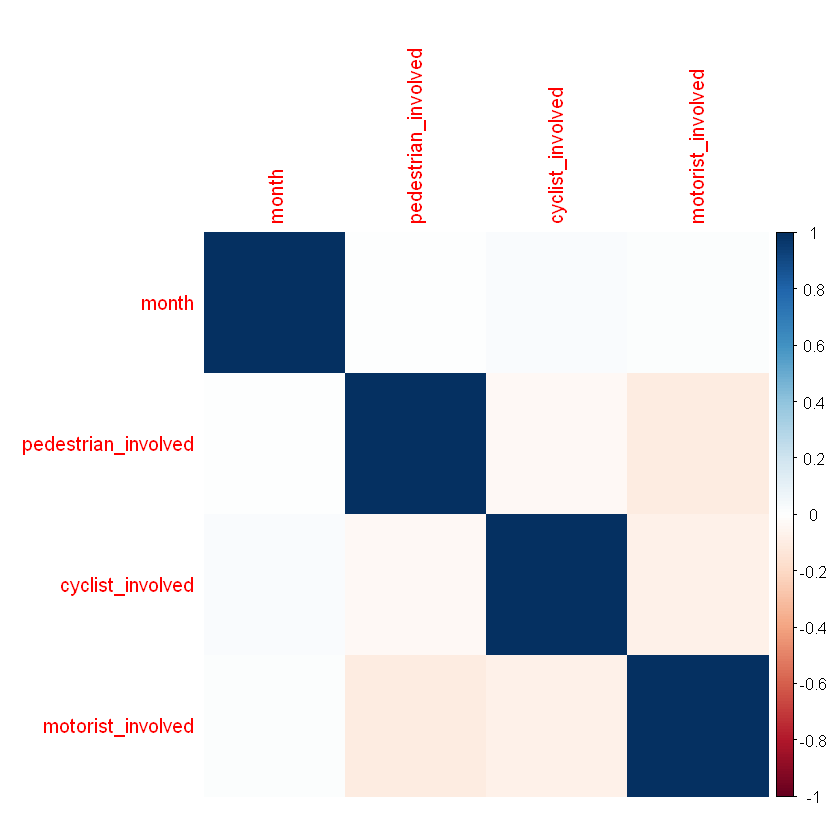

In [6]:
# Calculating correlation matrix for numeric features
cor_matrix <- cor(numeric_cols[,1:4])
# Let's plot correlation matrix for better visualization
corrplot(cor_matrix, method = "color")

In [7]:
cor_matrix

,month,pedestrian_involved,cyclist_involved,motorist_involved
month,1.000000000,0.006469457,0.02449612,0.01356967
pedestrian_involved,0.006469457,1.000000000,-0.03791336,-0.10106264
cyclist_involved,0.024496123,-0.037913364,1.00000000,-0.07693681
motorist_involved,0.013569670,-0.101062635,-0.07693681,1.00000000


**Interpretation:** 

There is a very weak positive correlation between the month and pedestrian involvement in accidents (correlation coefficient = 0.006).
There is a weak negative correlation between the month and cyclist involvement in accidents (correlation coefficient = -0.038).
There is a weak positive correlation between the month and motorist involvement in accidents (correlation coefficient = 0.014).
There is a weak negative correlation between pedestrian involvement and cyclist involvement in accidents (correlation coefficient = -0.038).
There is a weak negative correlation between pedestrian involvement and motorist involvement in accidents (correlation coefficient = -0.101).
There is a weak negative correlation between cyclist involvement and motorist involvement in accidents (correlation coefficient = -0.
077).
Overall, the correlations between these variables are weak, suggesting that there is little linear relationship between them.07).

In [8]:
head(df_cln)

,borough,month,time_period,Season,accident_factor,vehicle_category,pedestrian_involved,cyclist_involved,motorist_involved,total_victims
,<chr>,<int>,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1,MANHATTAN,9,Non Rush Hour,Fall,Human Error,Passenger Vehicles,0,0,1,4
2,MANHATTAN,3,Non Rush Hour,Spring,Environmental Factors,Passenger Vehicles,0,0,1,2
3,BRONX,6,Non Rush Hour,Summer,Human Error,Passenger Vehicles,0,0,0,0
4,BROOKLYN,9,Morning Rush Hour,Fall,Miscellaneous,Passenger Vehicles,0,0,0,0
5,BROOKLYN,12,Morning Rush Hour,Winter,Miscellaneous,Other,0,0,0,0
6,BRONX,4,Non Rush Hour,Spring,Miscellaneous,Commercial Vehicles,0,0,0,0


### Creting dummy variables

In [9]:
## Lets convert categorical data into dummy variables
dummy_feats <- c("borough", "time_period", "Season", "accident_factor", "vehicle_category")

# Creating dummy variables with drop_first=TRUE to remove one dummy per category
dummy_df <- dummy_cols(df_cln, select_columns = dummy_feats, remove_first_dummy = TRUE)


In [10]:
head(dummy_df)
dim(dummy_df)

,borough,month,time_period,Season,accident_factor,vehicle_category,pedestrian_involved,cyclist_involved,motorist_involved,total_victims,...,Season_Summer,Season_Winter,accident_factor_Human Error,accident_factor_Miscellaneous,accident_factor_Substance Use,accident_factor_Technology-related,accident_factor_Vehicle-related Issues,vehicle_category_Other,vehicle_category_Other Vehicles,vehicle_category_Passenger Vehicles
,<chr>,<int>,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,MANHATTAN,9,Non Rush Hour,Fall,Human Error,Passenger Vehicles,0,0,1,4,...,0,0,1,0,0,0,0,0,0,1
2,MANHATTAN,3,Non Rush Hour,Spring,Environmental Factors,Passenger Vehicles,0,0,1,2,...,0,0,0,0,0,0,0,0,0,1
3,BRONX,6,Non Rush Hour,Summer,Human Error,Passenger Vehicles,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
4,BROOKLYN,9,Morning Rush Hour,Fall,Miscellaneous,Passenger Vehicles,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,BROOKLYN,12,Morning Rush Hour,Winter,Miscellaneous,Other,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
6,BRONX,4,Non Rush Hour,Spring,Miscellaneous,Commercial Vehicles,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


[1] 1110808      27

### Train Test Split

In [11]:
# Creating a numeric vector to represent the indices of the training set
train_indices <- createDataPartition(dummy_df$total_victims, p = 0.70, list = FALSE)

# Spliting the dataset into training and testing set
train_data <- dummy_df[train_indices, ]
test_data <- dummy_df[-train_indices, ]

cat("Training data size:", nrow(train_data), "\n")
cat("Testing data size:", nrow(test_data), "\n")

Training data size: 777566 
Testing data size: 333242 


In [ ]:
names(train_data)

### Feature Selection

In [13]:
# feature selection using p-value
lm_model <- lm(total_victims ~ ., data = train_data)

# Check summary of the model
# summary(lm_model)

# Extract p-values for each coefficient
p_values <- summary(lm_model)$coefficients[, "Pr(>|t|)"]

# Select only features with p-values less than a certain threshold (e.g., 0.05)
significant_features <- names(p_values[p_values < 0.05])
significant_features

[1] "(Intercept)"                          
 [2] "boroughMANHATTAN"                     
 [3] "boroughQUEENS"                        
 [4] "boroughSTATEN ISLAND"                 
 [5] "time_periodEvening Rush Hour"         
 [6] "time_periodNon Rush Hour"             
 [7] "SeasonSummer"                         
 [8] "accident_factorHuman Error"           
 [9] "accident_factorMiscellaneous"         
[10] "accident_factorSubstance Use"         
[11] "accident_factorVehicle-related Issues"
[12] "vehicle_categoryOther"                
[13] "vehicle_categoryPassenger Vehicles"   
[14] "pedestrian_involved"                  
[15] "cyclist_involved"                     
[16] "motorist_involved"

In [14]:
significant_features <- c('total_victims', 'pedestrian_involved', 'cyclist_involved', 'motorist_involved', 'month',
                       'borough_BROOKLYN', 'borough_MANHATTAN', 'borough_QUEENS', 'borough_STATEN ISLAND', 
                       'time_period_Evening Rush Hour', 'Season_Spring', 
                       'Season_Summer', 'accident_factor_Human Error', 
                        'accident_factor_Substance Use', 'accident_factor_Vehicle-related Issues', 
                       'vehicle_category_Other', 'vehicle_category_Passenger Vehicles')

In [15]:
train_data_filtered <- train_data[,significant_features]

In [16]:
dim(train_data_filtered)

[1] 777566     17

In [17]:
features_vec <- c('pedestrian_involved', 'cyclist_involved', 'motorist_involved', 'month',
                       'borough_BROOKLYN', 'borough_MANHATTAN', 'borough_QUEENS', 'borough_STATEN ISLAND', 
                       'time_period_Evening Rush Hour', 'Season_Spring', 
                       'Season_Summer', 'accident_factor_Human Error', 
                        'accident_factor_Substance Use', 'accident_factor_Vehicle-related Issues', 
                       'vehicle_category_Other', 'vehicle_category_Passenger Vehicles')

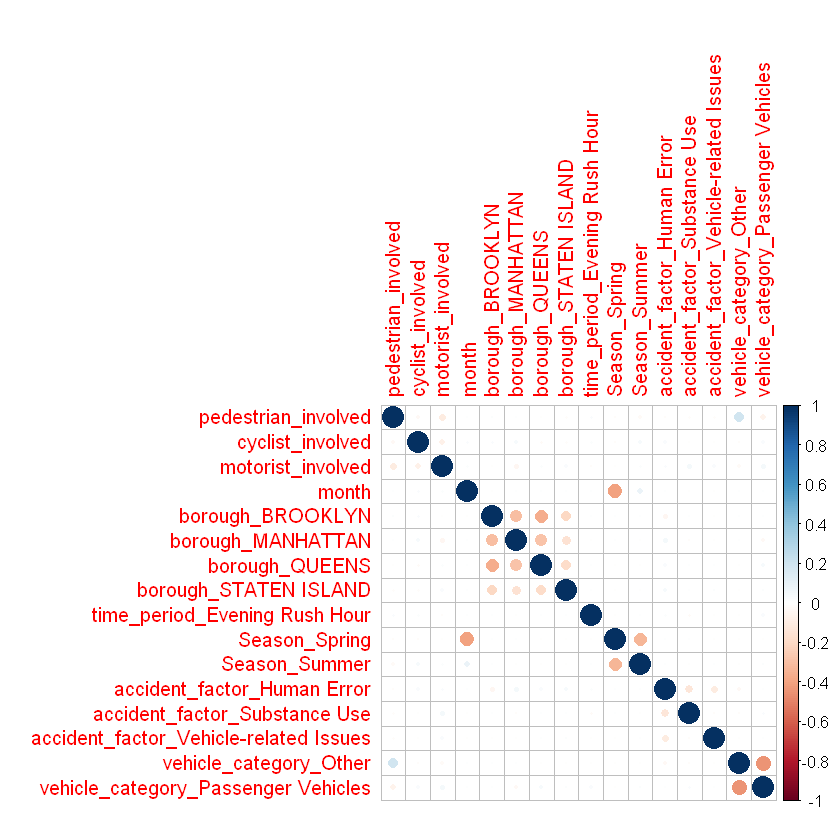

In [18]:
# checking if any features are correlated to each other
cor_matrix <- cor(train_data_filtered[, features_vec])

# let's plot the correlation matrix
corrplot::corrplot(cor_matrix, method = "circle")

In this case, while there are some correlations among the variables, none of them are exceptionally high (above 0.7 or below -0.7).
Therefore, based on the correlation matrix, the multicollinearity assumption can be considered to pass, as there are no extremely high correlations among the independent variables

In [19]:
# resetting index value
rownames(train_data_filtered) <- NULL
rownames(test_data) <- NULL


### Model building

In [20]:
# Fit a linear regression model
lm_model <- lm(total_victims ~ ., data = train_data_filtered)

# Print the summary of the model
summary(lm_model)


Call:
lm(formula = total_victims ~ ., data = train_data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0164 -0.0236 -0.0102  0.0005  7.9234 

Coefficients:
                                           Estimate Std. Error  t value
(Intercept)                               0.0063813  0.0041894    1.523
pedestrian_involved                       2.0743237  0.0034244  605.752
cyclist_involved                          2.0159222  0.0044603  451.971
motorist_involved                         2.9366206  0.0021044 1395.439
month                                     0.0006896  0.0002484    2.776
borough_BROOKLYN                         -0.0027589  0.0023551   -1.171
borough_MANHATTAN                        -0.0178194  0.0025623   -6.954
borough_QUEENS                           -0.0145490  0.0024191   -6.014
`borough_STATEN ISLAND`                  -0.0069134  0.0031362   -2.204
`time_period_Evening Rush Hour`          -0.0037360  0.0022552   -1.657
Season_Spring                   

Residual standard error: This represents the standard deviation of the residuals, which are the differences between the observed and predicted values. In this case, the residual standard error is approximately 0.6863.

Multiple R-squared: This value indicates the proportion of variance in the dependent variable (total_victims) that is explained by the independent variables in the model. An R-squared of 0.7468 means that approximately 74.68% of the variance in the total number of victims is explained by the independent variables included in the model.

Adjusted R-squared: This value is similar to R-squared but adjusts for the number of predictors in the model. It penalizes the addition of unnecessary predictors that do not improve the model's fit. In this case, the adjusted R-squared is also 0.7468.

F-statistic: This is the ratio of the mean square regression to the mean square error. It tests the overall significance of the regression model. A higher F-statistic indicates that the model is more likely to be significant. Here, the F-statistic is quite high, with a value of 1.433e+05.

p-value: This represents the probability of observing the F-statistic or a more extreme value if the null hypothesis (that all regression coefficients are equal to zero) is true. A p-value less than the significance level (typically 0.05) suggests that at least one independent variable is significantly related to the dependent variable. In this case, the p-value is very close to zero, indicating that the regression model is significant.

In [21]:
predicted <- predict(lm_model, data = test_data[,features_vec])

# Evaluate the model
mse <- mean((test_data$total_victims - predicted)^2)  # Mean Squared Error
rmse <- sqrt(mse)                                     # Root Mean Squared Error
rsquared <- summary(lm_model)$r.squared                # R-squared

# Print evaluation metrics
cat("Mean Squared Error (MSE):", mse, "\n")
cat("Root Mean Squared Error (RMSE):", rmse, "\n")
cat("R-squared:", rsquared, "\n")

Warning message in test_data$total_victims - predicted:
"longer object length is not a multiple of shorter object length"


Mean Squared Error (MSE): 3.277386 
Root Mean Squared Error (RMSE): 1.810355 
R-squared: 0.7467907 


In [22]:
# Converting test_data to data.table
setDT(test_data)

# Using data.table's for fast row-wise operation
test_data[, predicted_total_victims := predict(lm_model, newdata = .SD), .SDcols = names(test_data)[!names(test_data) %in% "predicted_total_victims"]]

### Interpretation of result:

Mean Squared Error (MSE): This metric measures the average squared difference between the actual and predicted values. It is calculated by averaging the squared differences between each predicted value and its corresponding actual value. In this case, the MSE is 3.280748.

Root Mean Squared Error (RMSE): This is the square root of the MSE. It provides an estimate of the standard deviation of the errors made by the model in its predictions. In this case, the RMSE is 1.811284.

R-squared (R²): This metric indicates the proportion of the variance in the dependent variable (total_victims) that is predictable from the independent variables (features) in the model. It ranges from 0 to 1, where 1 indicates a perfect fit. In this case, the R-squared value is 0.7477388, indicating that approximately 74.77% of the variance in the total number of victims is explained by the independent variables included in the mod

el.
Overall, the model appears to have decent predictive performance, with a relatively low MSE and RMSE and a moderately high R-squared value.

In [23]:
max(test_data$predicted_total_victims)

[1] 7.042311

### Feature Importance

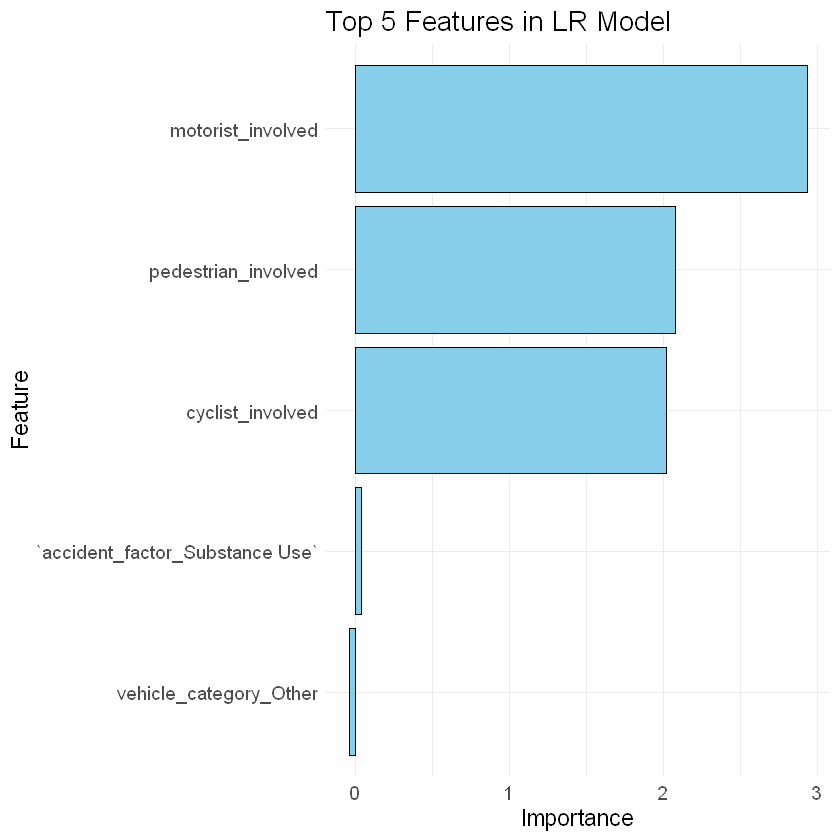

In [27]:
coefficients <- coef(lm_model)

# Sorting coefficients by absolute magnitude
coefficients_sorted <- coefficients[order(abs(coefficients), decreasing = TRUE)]

top_5 <- coefficients_sorted[1:5]

# Creating a data frame for plotting
plot_data <- data.frame(
  Feature = names(top_5),
  Importance = top_5
)

# Plotting
library(ggplot2)

ggplot(plot_data, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") +
  coord_flip() +  
  labs(x = "Feature", y = "Importance", title = "Top 5 Features in LR Model") +
  theme_minimal() +
  theme(text = element_text(size = 14))

In [25]:
plot_data

,Feature,Importance
,<chr>,<dbl>
motorist_involved,motorist_involved,2.93662061
pedestrian_involved,pedestrian_involved,2.07432368
cyclist_involved,cyclist_involved,2.01592217
`accident_factor_Substance Use`,`accident_factor_Substance Use`,0.04087310
vehicle_category_Other,vehicle_category_Other,-0.03708992


These importance values indicate the relative importance of each feature in your analysis. Positive values suggest a positive impact on the target variable, while negative values suggest a negative impact

### Regression Plot

`geom_smooth()` using formula = 'y ~ x'


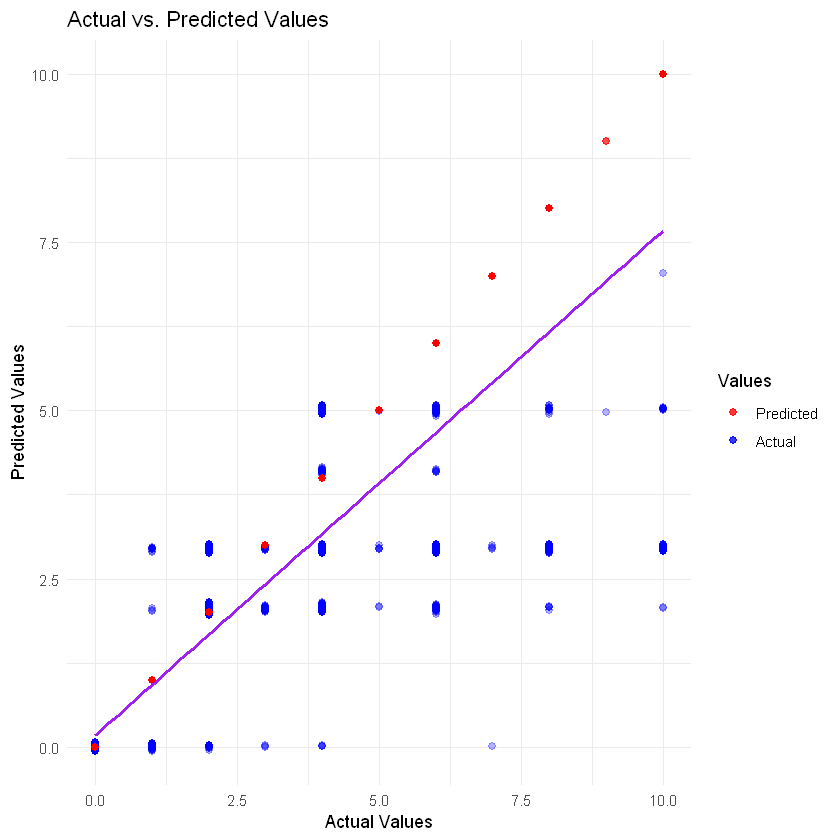

In [26]:
# let's plot the regression line on test data
ggplot(test_data, aes(x = total_victims)) +
  geom_point(aes(y = predicted_total_victims, color = "Predicted"), alpha = 0.3, size = 2) +  # Predicted values with lower alpha and larger size
  geom_point(aes(y = total_victims, color = "Actual"), alpha = 0.7, size = 2) +  # Actual values with higher alpha and larger size
  geom_smooth(aes(y = predicted_total_victims), method = "lm", se = FALSE, color = "purple") +  # Regression line
  scale_color_manual(name = "Values", values = c("Predicted" = "blue", "Actual" = "red"), labels = c("Predicted", "Actual")) +  # Add legend
  labs(x = "Actual Values", y = "Predicted Values", title = "Actual vs. Predicted Values") +
  theme_minimal()

Lets see how well our model able to predict the total_victims, It's scatter plot of actual values vs predicted values , red dots represent predicted values and blue shows a actual values.we're seeing less red dots compared to blue that's because they're overlapping. if you line doesn't start from 0 it starts from >0 on Y-axis that point is called as intercept.
Intercept:  This value, 0.0063813, represents the y-intercept of the regression line. It signifies the predicted value of the dependent variable on the y-axis when the independent variable (x) is zero. In simpler terms, it's the point where the regression line crosses the y-axis.
Overall our model fairly captures relationship between dependet variable and independents variables.
There will always be some data points that fall above or below the line.
